In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn.utils.prune as prune
import pandas as pd
import numpy as np

In [35]:
from transformers import GPT2Model
model = GPT2Model.from_pretrained('gpt2')

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 665/665 [00:00<00:00, 254kB/s]
Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 548M/548M [00:12<00:00, 43.1MB/s]


In [63]:
def prune_model(model):
    def flatten(m):
        f = [x for c in m.children() for x in flatten(c)]
        if len(f) == 0:
            return [m]
        else:
            return f
    layers = flatten(model)
    params_to_prune = [(m, p[0]) for m in layers for p in m.named_parameters()]
    
    prune.global_unstructured(
        params_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=0.2,
    )

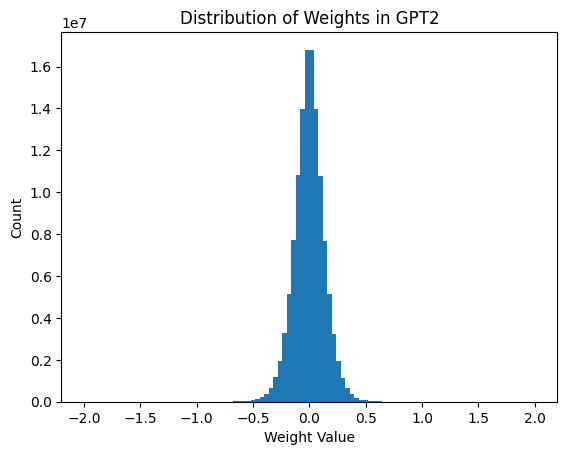

In [36]:
parameters = [p.flatten() for p in model.parameters() if p.requires_grad]
parameters = torch.cat(parameters)
hist = torch.histogram(parameters, range=(-2,2), bins=100)
bin_edges = hist.bin_edges.detach().numpy()
height = hist.hist.detach().numpy()
width = np.diff(bin_edges)
plt.title("Distribution of Weights in GPT2")
plt.bar(bin_edges[:-1], height, width=width, align='edge')
plt.xlabel("Weight Value")
plt.ylabel("Count")
plt.savefig("../results/figs/gpt2-weight-distribution.png")
plt.show()

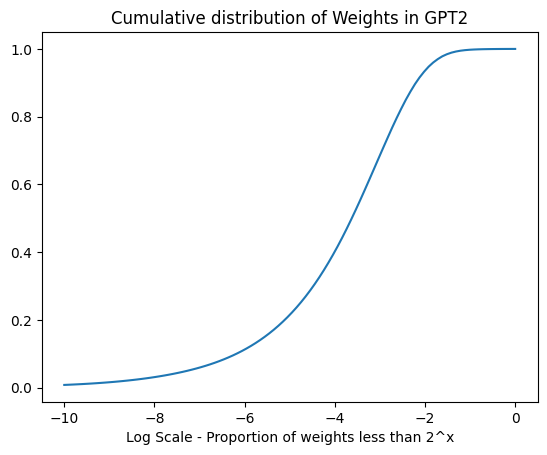

In [38]:
thresholds = np.linspace(0, -10, 100)
counts = np.zeros_like(thresholds)
for i in range(len(thresholds)):
    counts[i] = torch.count_nonzero(torch.abs(parameters) < np.power(2., thresholds[i]))
    
proportion = counts/parameters.shape[0]
plt.plot(thresholds, proportion)
plt.title("Cumulative distribution of Weights in GPT2")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")
plt.savefig("../results/figs/gpt2-weight-cdf.png")

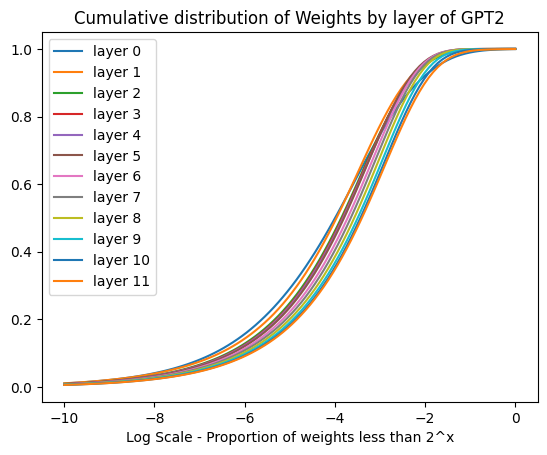

In [39]:
for j, layer in enumerate(model.h):
    thresholds = np.linspace(0, -10, 100)
    parameters = [p.flatten() for p in layer.parameters() if p.requires_grad]
    parameters = torch.cat(parameters)    
    counts = np.zeros_like(thresholds)
    for i in range(len(thresholds)):
        counts[i] = torch.count_nonzero(torch.abs(parameters) < np.power(2., thresholds[i]))

    proportion = counts/parameters.shape[0]
    plt.plot(thresholds, proportion, label=f"layer {j}")
             
plt.title(f"Cumulative distribution of Weights by layer of GPT2")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")
plt.legend()
plt.savefig("../results/figs/gpt2-layer-cdf.png")
plt.show()

In [40]:
from transformers import RobertaModel
model = RobertaModel.from_pretrained("roberta-large")

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


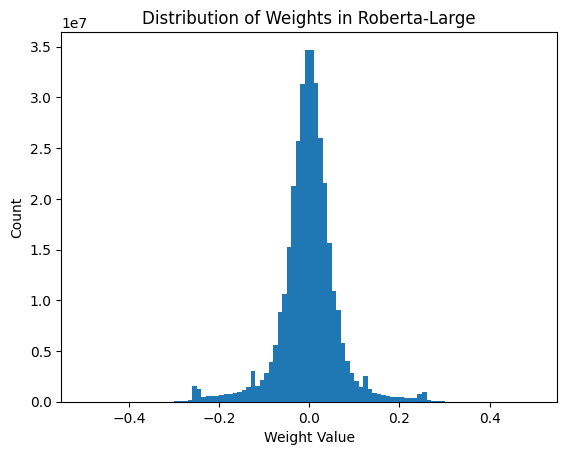

In [41]:
parameters = [p.flatten() for p in model.parameters() if p.requires_grad]
parameters = torch.cat(parameters)
hist = torch.histogram(parameters, range=(-0.5,.5), bins=100)
bin_edges = hist.bin_edges.detach().numpy()
height = hist.hist.detach().numpy()
width = np.diff(bin_edges)
plt.title("Distribution of Weights in Roberta-Large")
plt.bar(bin_edges[:-1], height, width=width, align='edge')
plt.xlabel("Weight Value")
plt.ylabel("Count")
plt.savefig("../results/figs/roberta-weight-distribution.png")
plt.show()

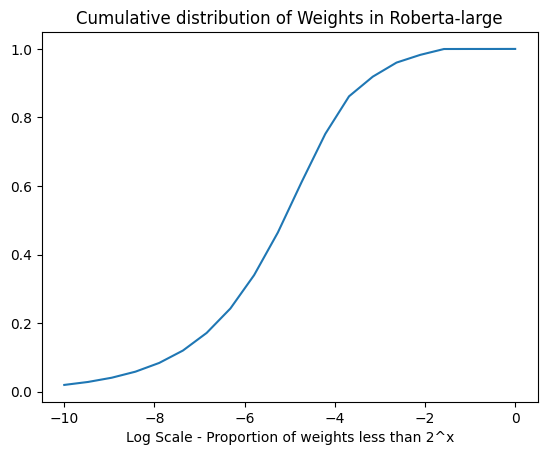

In [42]:
thresholds = np.linspace(0, -10, 20)
counts = np.zeros_like(thresholds)
for i in range(len(thresholds)):
    counts[i] = torch.count_nonzero(torch.abs(parameters) < np.power(2., thresholds[i]))
    
proportion = counts/parameters.shape[0]
plt.plot(thresholds, proportion)
plt.title("Cumulative distribution of Weights in Roberta-large")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")
plt.savefig("../results/figs/roberta-weight-cdf.png")
plt.show()

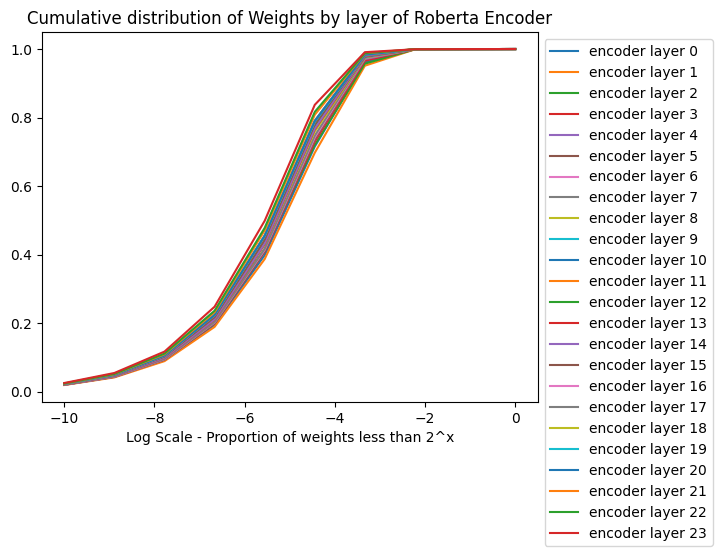

In [43]:
for j, layer in enumerate(model.encoder.layer):
    thresholds = np.linspace(0, -10, 10)
    parameters = [p.flatten() for p in layer.parameters() if p.requires_grad]
    parameters = torch.cat(parameters)    
    counts = np.zeros_like(thresholds)
    for i in range(len(thresholds)):
        counts[i] = torch.count_nonzero(torch.abs(parameters) < np.power(2., thresholds[i]))

    proportion = counts/parameters.shape[0]
    plt.plot(thresholds, proportion, label=f"encoder layer {j}")
    
plt.title(f"Cumulative distribution of Weights by layer of Roberta Encoder")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig("../results/figs/roberta-layer-cdf.png")
plt.show()

In [44]:
from transformers import PegasusModel
model = PegasusModel.from_pretrained("google/pegasus-large")

Some weights of the model checkpoint at google/pegasus-large were not used when initializing PegasusModel: ['final_logits_bias']
- This IS expected if you are initializing PegasusModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing PegasusModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of PegasusModel were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


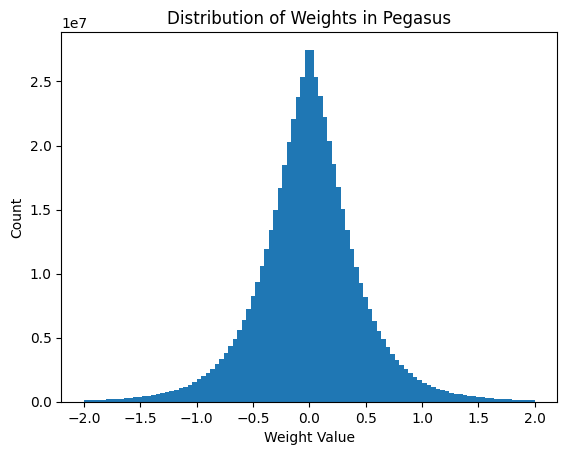

In [45]:
parameters = [p.flatten() for p in model.parameters() if p.requires_grad]
parameters = torch.cat(parameters)
hist = torch.histogram(parameters, range=(-2,2), bins=100)
bin_edges = hist.bin_edges.detach().numpy()
height = hist.hist.detach().numpy()
width = np.diff(bin_edges)
plt.title("Distribution of Weights in Pegasus")
plt.bar(bin_edges[:-1], height, width=width, align='edge')
plt.xlabel("Weight Value")
plt.ylabel("Count")
plt.savefig("../results/figs/pegasus-weight-distribution.png")
plt.show()

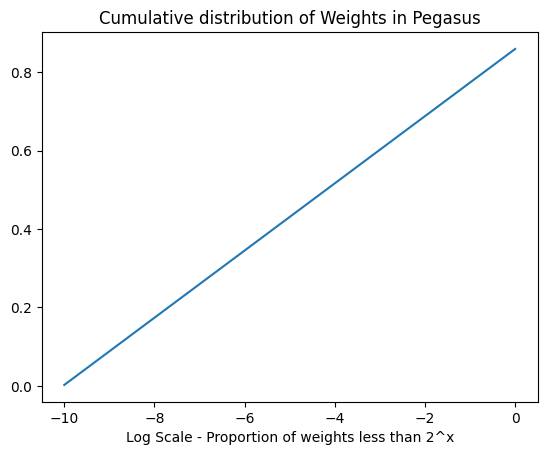

In [55]:
thresholds = np.linspace(0, -10, 2)
counts = np.zeros_like(thresholds)
for i in range(len(thresholds)):
    counts[i] = torch.count_nonzero(torch.abs(parameters) < np.power(2., thresholds[i]))
    
proportion = counts/parameters.shape[0]
plt.plot(thresholds, proportion)
plt.title("Cumulative distribution of Weights in Pegasus")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")
plt.savefig("../results/figs/pegasus-wight-cdf.png")
plt.show()

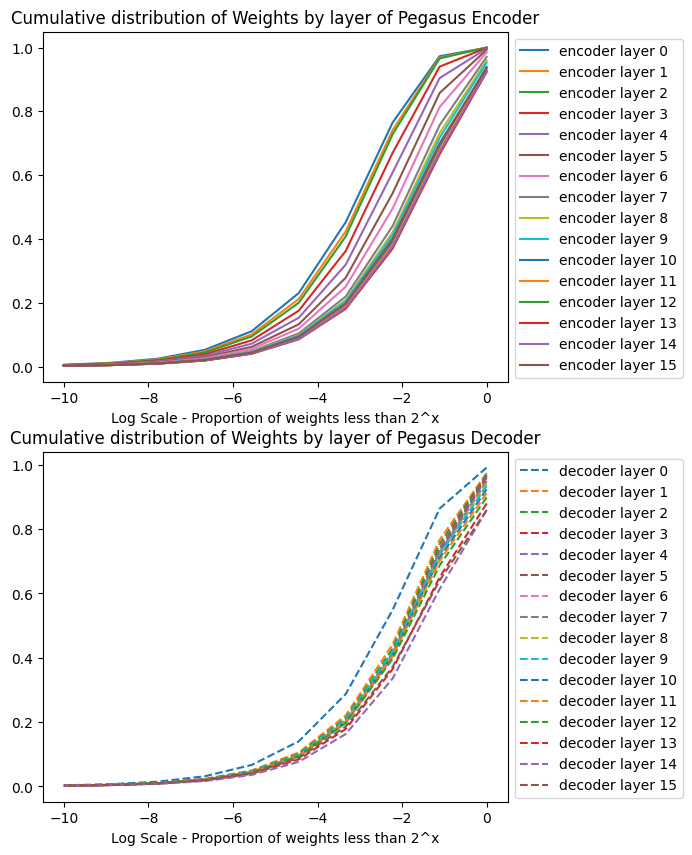

In [56]:
plt.figure(figsize=(6,10))
plt.subplot(2,1,1)
for j, layer in enumerate(model.encoder.layers):
    thresholds = np.linspace(0, -10, 10)
    parameters = [p.flatten() for p in layer.parameters() if p.requires_grad]
    parameters = torch.cat(parameters)    
    counts = np.zeros_like(thresholds)
    for i in range(len(thresholds)):
        counts[i] = torch.count_nonzero(torch.abs(parameters) < np.power(2., thresholds[i]))

    proportion = counts/parameters.shape[0]
    plt.plot(thresholds, proportion, label=f"encoder layer {j}")
    
plt.title(f"Cumulative distribution of Weights by layer of Pegasus Encoder")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    
plt.subplot(2,1,2)
for j, layer in enumerate(model.decoder.layers):
    thresholds = np.linspace(0, -10, 10)
    parameters = [p.flatten() for p in layer.parameters() if p.requires_grad]
    parameters = torch.cat(parameters)    
    counts = np.zeros_like(thresholds)
    for i in range(len(thresholds)):
        counts[i] = torch.count_nonzero(torch.abs(parameters) < np.power(2., thresholds[i]))

    proportion = counts/parameters.shape[0]
    plt.plot(thresholds, proportion, label=f"decoder layer {j}", linestyle="--")
             
plt.title(f"Cumulative distribution of Weights by layer of Pegasus Decoder")
plt.xlabel("Log Scale - Proportion of weights less than 2^x")
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.savefig("../results/figs/pegasus-layer-cdf.png")
plt.show()

In [2]:
df = pd.read_csv("../results/results.csv")
df.head()

,model,sparsity,task,fine-tuning,accuracy,perplexity,samples_per_second
0,GPT2,0.0,lm,0,0.3791,30.6306,72.090
1,GPT2,0.0,lm,1,0.4225,21.5610,71.837
2,GPT2,0.1,lm,0,0.3764,31.1309,52.379
3,GPT2,0.1,lm,1,0.4220,21.6392,71.680
4,GPT2,0.5,lm,0,0.0192,8015.4958,55.498


In [3]:
finetuned = df[df["fine-tuning"] == 1]
finetuned_lm = finetuned[finetuned["task"] == "lm"]
finetuned_lm.head()

,model,sparsity,task,fine-tuning,accuracy,perplexity,samples_per_second
1,GPT2,0.00,lm,1,0.4225,21.5610,71.837
3,GPT2,0.10,lm,1,0.4220,21.6392,71.680
5,GPT2,0.50,lm,1,0.3653,34.7310,71.520
7,GPT2,0.90,lm,1,0.1270,830.6939,71.503
9,GPT2,0.95,lm,1,0.0734,1448.0163,71.749


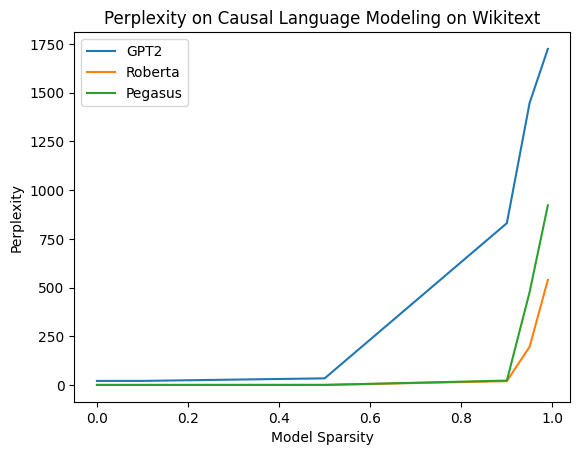

In [4]:
for model in finetuned_lm["model"].unique():
    data = finetuned_lm[finetuned_lm["model"] == model]
    plt.plot(data["sparsity"], data["perplexity"], label=model)
plt.legend()
plt.title("Perplexity on Causal Language Modeling on Wikitext")
plt.xlabel("Model Sparsity")
plt.ylabel("Perplexity")
plt.savefig("../results/figs/clm-results.png")
plt.show()

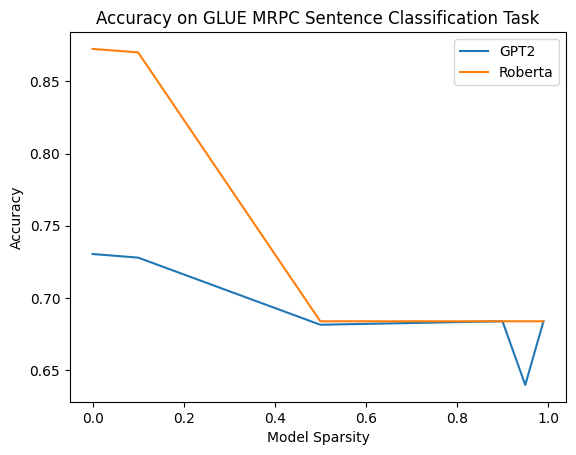

In [10]:
finetuned_mrpc = finetuned[finetuned["task"] == "mrpc"]
for model in finetuned_mrpc["model"].unique():
    data = finetuned_mrpc[finetuned_mrpc["model"] == model]
    plt.plot(data["sparsity"], data["accuracy"], label=model)
plt.legend()
plt.title("Accuracy on GLUE MRPC Sentence Classification Task")
plt.xlabel("Model Sparsity")
plt.ylabel("Accuracy")
plt.savefig("../results/figs/mrpc-results.png")
plt.show()

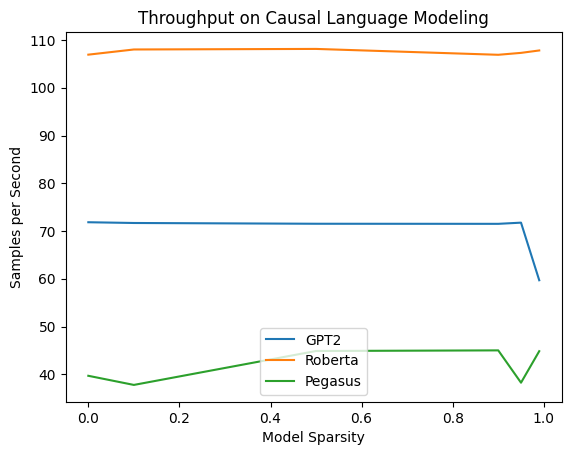

In [11]:
for model in finetuned_lm["model"].unique():
    data = finetuned_lm[finetuned_lm["model"] == model]
    plt.plot(data["sparsity"], data["samples_per_second"], label=model)
plt.legend()
plt.title("Throughput on Causal Language Modeling")
plt.xlabel("Model Sparsity")
plt.ylabel("Samples per Second")
plt.savefig("../results/figs/throughput-results.png")
plt.show()

In [12]:
df = pd.read_csv("../results/sizes.csv")
df = df.transpose()
df.columns = df.iloc[0]
df = df.iloc[1:]
df["sparsity"] = df.index
df.head()

Model,GPT2,Roberta,Pegasus,sparsity
0.1,363107424,779043977,1987057445,0.1
0.5,281604733,520724178,1257989200,0.5
0.9,95089584,189402363,415237585,0.9
0.95,95089584,140756729,296047868,0.95
0.99,41444133,103675040,188425991,0.99


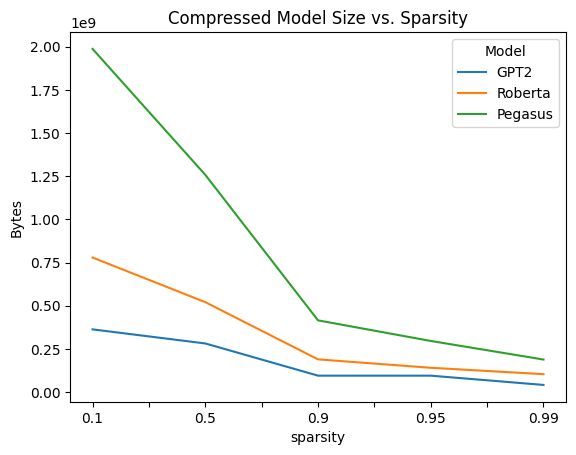

In [15]:
df.plot("sparsity", ["GPT2", "Roberta", "Pegasus"])
plt.title("Compressed Model Size vs. Sparsity")
plt.ylabel("Bytes")
plt.savefig("../results/figs/sive_vs_sparsity.png")
plt.show()